# Reparameterisation with GNNs
This notebook contains the training results of VIP reparameterisation where the temperatures of reparametersation (i.e., $\lambda \in [0, 1]$) are provided by GNNs.

In [1]:
import os
import pyro
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as to
import pyro.optim  as po
from tqdm.auto import tqdm
from pyro.infer import Trace_ELBO
from pyro.poutine import reparam

os.chdir("../")
from VIPReparam import VIPReparam
from AutoReparam import GNN, AutoReparam
from model import neals_funnel, eight_schools
from util import plot_scatter3d
torch.set_default_device("cuda:0")

### Neal's Funnel
Here we use variants of the Neal's Funnel example which contain randomly generated observed variables $y \in (-20, 20)$ and noises $\sigma \in (0, 20)$.

>>> Training SVI only


  0%|          | 0/1000 [00:00<?, ?it/s]

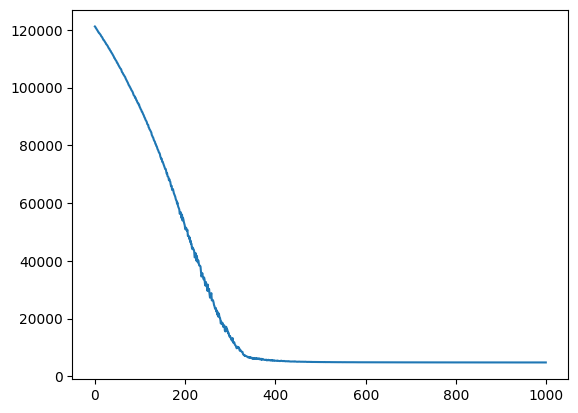

>>> Training SVI and GNN


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

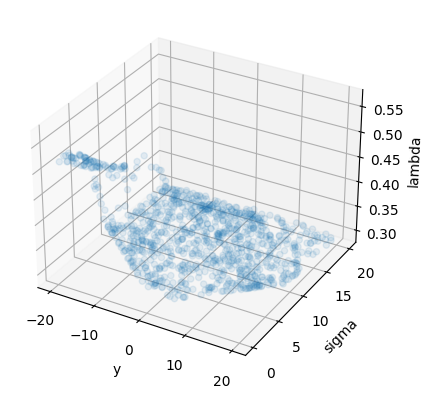

  0%|          | 0/1000 [00:00<?, ?it/s]

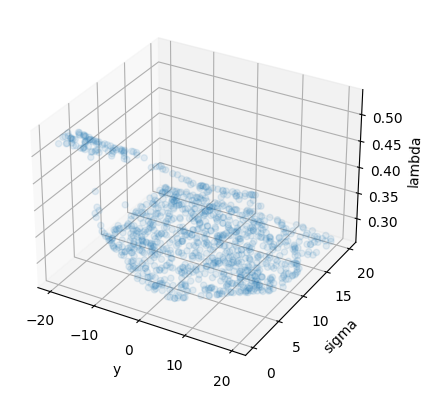

  0%|          | 0/1000 [00:00<?, ?it/s]

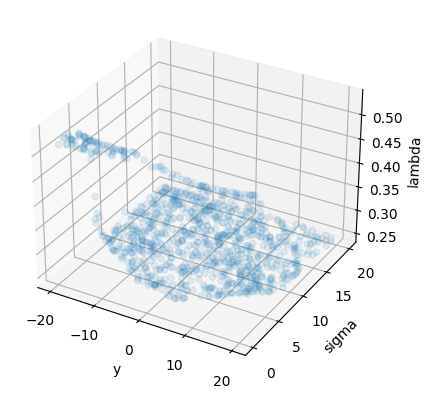

  0%|          | 0/1000 [00:00<?, ?it/s]

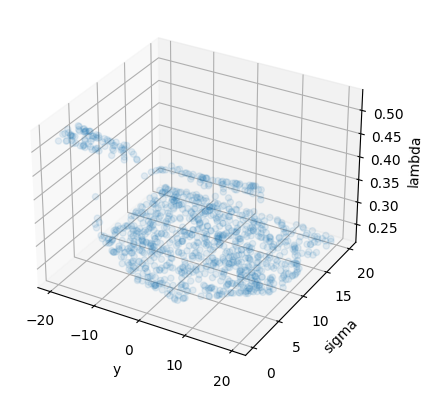

  0%|          | 0/1000 [00:00<?, ?it/s]

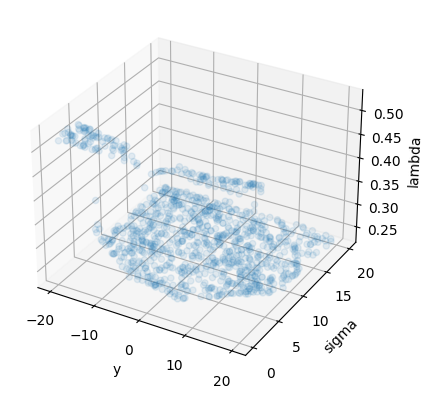

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [3]:
%matplotlib inline
pyro.clear_param_store()
n_hidden = 3
n_layer = 5
n_model = 1000

model = neals_funnel
batch_depth = 1

gnn = GNN(n_hidden, n_layer)
y = torch.rand(n_model) * 40 - 20
sigma = torch.rand(n_model) * 20
loss = Trace_ELBO(num_particles=100, vectorize_particles=True)


print(">>> Training SVI only")
optim_gnn = po.clipped_adam.ClippedAdam(gnn.parameters(), lr=0)
optim_svi = po.ClippedAdam({"lr": 1e-2})
optims = {"gnn": optim_gnn, "svi": optim_svi}
funnel = AutoReparam(gnn, optims, loss, model, batch_depth, y, sigma)

losses = []
for _ in (epoch := tqdm(range(1000))):
    _loss = funnel.step()
    epoch.set_description("Loss: {:.4}".format(_loss))
    losses.append(_loss)
    
plt.figure()
plt.plot(np.array(losses))
plt.show()


print(">>> Training SVI and GNN")
optim_gnn = po.clipped_adam.ClippedAdam(gnn.parameters(), lr=1e-2)
optim_svi = po.ClippedAdam({"lr": 1e-2})
optims = {"gnn": optim_gnn, "svi": optim_svi}
funnel = AutoReparam(gnn, optims, loss, model, batch_depth, y, sigma)

losses = []
for _ in tqdm(range(10)):
    for _ in (epoch := tqdm(range(1000))):
        _loss = funnel.step()
        epoch.set_description("Loss: {:.4}".format(_loss))
        losses.append(_loss)
    context = funnel.get_context("x")
    plot_scatter3d(y, sigma, context, xlabel="y", ylabel="sigma", zlabel="lambda", alpha=0.1)

plt.figure()
plt.plot(np.array(losses))
plt.show()

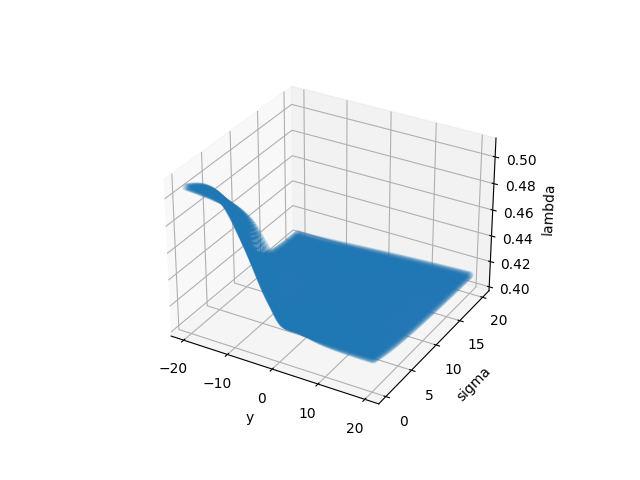

In [13]:
%matplotlib widget
bound = 20
step = 100
yy, ss = torch.meshgrid(torch.linspace(-bound, bound, step), torch.linspace(0.1, bound, step), indexing="ij")
y = yy.flatten()
sigma = ss.flatten()

funnel = AutoReparam(gnn, None, None, model, batch_depth, y, sigma)
context = funnel.get_context("x")
plot_scatter3d(yy, ss, context, xlabel="y", ylabel="sigma", zlabel="lambda", alpha=0.1)

### Eight Schools
Here we use `Eight Schools` examples whose observed values and noises of the first school are randomly generated as $y \in (-20, 20)$ and $\sigma \in (0, 20)$, and those of the other schools are fixed as $0$ and $1$.

>>> Training SVI only


  0%|          | 0/1000 [00:00<?, ?it/s]

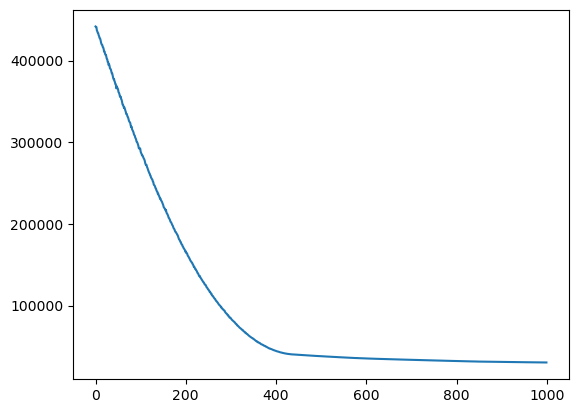

>>> Training SVI and GNN


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

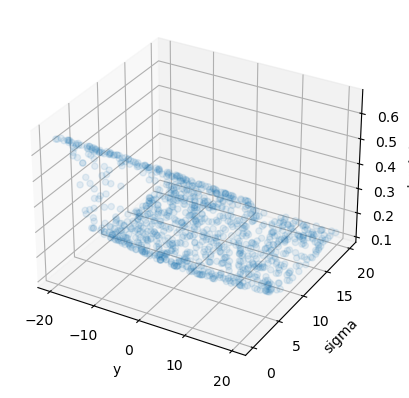

  0%|          | 0/1000 [00:00<?, ?it/s]

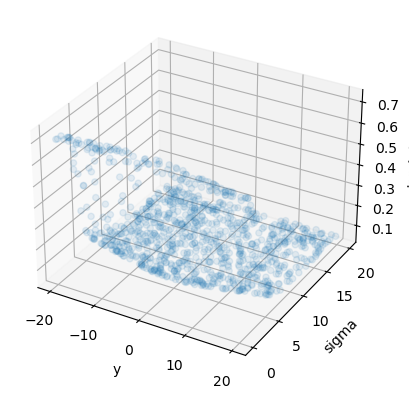

  0%|          | 0/1000 [00:00<?, ?it/s]

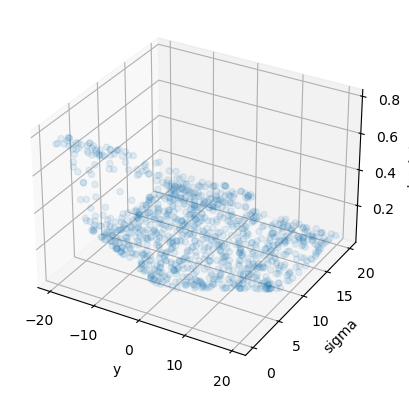

  0%|          | 0/1000 [00:00<?, ?it/s]

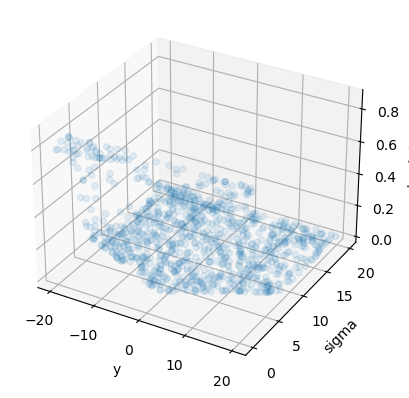

  0%|          | 0/1000 [00:00<?, ?it/s]

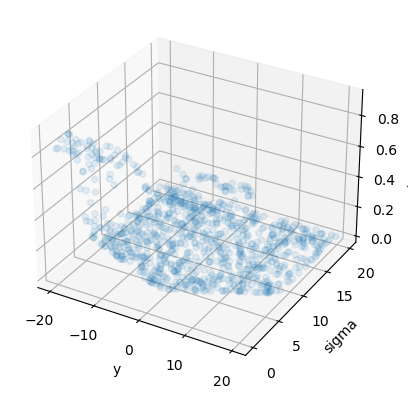

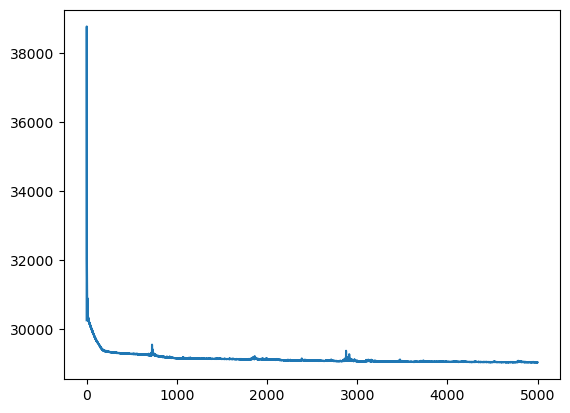

In [11]:
%matplotlib inline
pyro.clear_param_store()
n_hidden = 32
n_layer = 5
n_model = 1000
n_school = 8

model = eight_schools
batch_depth = 2

gnn = GNN(n_hidden, n_layer)
y = torch.cat([torch.rand(1, n_model) * 40 - 20, torch.zeros(n_school - 1, n_model)])
sigma = torch.cat([torch.rand(1, n_model) * 20, torch.ones(n_school - 1, n_model)])
loss = Trace_ELBO(num_particles=100, vectorize_particles=True)


print(">>> Training SVI only")
optim_gnn = po.clipped_adam.ClippedAdam(gnn.parameters(), lr=0)
optim_svi = po.ClippedAdam({"lr": 1e-2})
optims = {"gnn": optim_gnn, "svi": optim_svi}
schools = AutoReparam(gnn, optims, loss, model, batch_depth, y, sigma)

losses = []
for _ in (epoch := tqdm(range(1000))):
    _loss = schools.step()
    epoch.set_description("Loss: {:.4}".format(_loss))
    losses.append(_loss)

plt.figure()
plt.plot(np.array(losses))
plt.show()


print(">>> Training SVI and GNN")
optim_gnn = po.clipped_adam.ClippedAdam(gnn.parameters(), lr=1e-2)
optim_svi = po.ClippedAdam({"lr": 1e-2})
optims = {"gnn": optim_gnn, "svi": optim_svi}
schools = AutoReparam(gnn, optims, loss, model, batch_depth, y, sigma)

losses = []
for _ in tqdm(range(5)):
    for _ in (epoch := tqdm(range(1000))):
        _loss = schools.step()
        epoch.set_description("Loss: {:.4}".format(_loss))
        losses.append(_loss)
    context = schools.get_context("theta")
    plot_scatter3d(y[0], sigma[0], context[0], xlabel="y", ylabel="sigma", zlabel="lambda", alpha=0.1)

plt.figure()
plt.plot(np.array(losses))
plt.show()

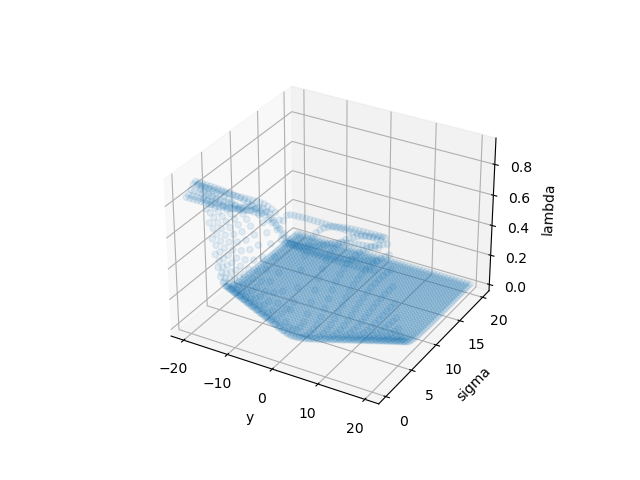

In [12]:
%matplotlib widget
bound = 20
step = 50
yy, ss = torch.meshgrid(torch.linspace(-bound, bound, step), torch.linspace(0.1, bound, step), indexing="ij")
y = torch.cat([yy.reshape(1, -1), torch.zeros(n_school - 1, step ** 2)])
sigma = torch.cat([ss.reshape(1, -1), torch.ones(n_school - 1, step ** 2)])

schools = AutoReparam(gnn, None, None, model, batch_depth, y, sigma)
context = schools.get_context("theta").reshape((n_school,) + yy.shape)
plot_scatter3d(yy, ss, context[0], xlabel="y", ylabel="sigma", zlabel="lambda", alpha=0.1)